In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import lifelines # for survival analysis
from sklearn.preprocessing import LabelEncoder

In [2]:
 df=pd.read_csv("Downloads/EA.csv", sep=",")

In [3]:
# Look at the categorical and numerical variables
summary_categorical =[]
for column in df.columns:
    if df[column].dtype == object:
        summary_categorical.append(column)
        print(df[column].value_counts())
        print(f"------------------")
summary_numerical=[]
for column in df.columns:
    if df[column].dtype != object:
        print(f"{column} : Minimum: {min((df[column].unique()))}, Maximum: {max((df[column].unique()))} ")
        summary_numerical.append(column)
        print(f"----------------------------------")

Attrition
No     1233
Yes     237
Name: count, dtype: int64
------------------
BusinessTravel
Travel_Rarely        1043
Travel_Frequently     277
Non-Travel            150
Name: count, dtype: int64
------------------
Department
Research & Development    961
Sales                     446
Human Resources            63
Name: count, dtype: int64
------------------
EducationField
Life Sciences       606
Medical             464
Marketing           159
Technical Degree    132
Other                82
Human Resources      27
Name: count, dtype: int64
------------------
Gender
Male      882
Female    588
Name: count, dtype: int64
------------------
JobRole
Sales Executive              326
Research Scientist           292
Laboratory Technician        259
Manufacturing Director       145
Healthcare Representative    131
Manager                      102
Sales Representative          83
Research Director             80
Human Resources               52
Name: count, dtype: int64
------------------
Mar

In [4]:
#Convert the Attrition into binary variable:
encoder = LabelEncoder()
df['Attrition'] = encoder.fit_transform(df['Attrition'])

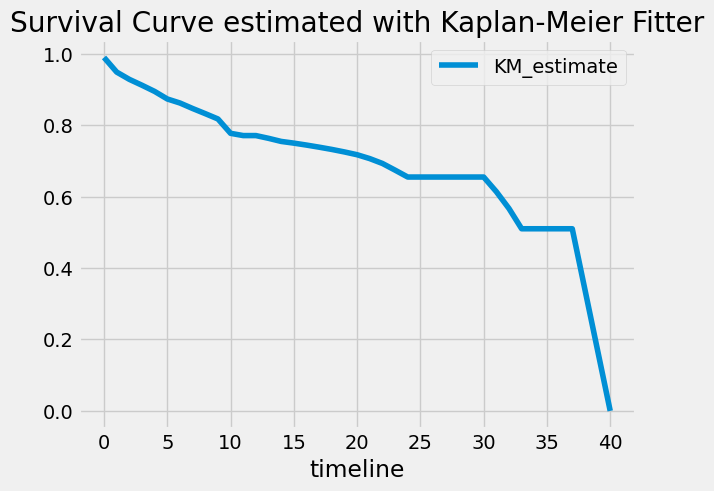

In [5]:
##Kaplan-Meier Estimator    
from lifelines import KaplanMeierFitter
# Initiate and fit
kmf = KaplanMeierFitter()
kmf.fit(durations=df.YearsAtCompany, event_observed =df.Attrition)
# Plot the survival function
kmf.survival_function_.plot()
plt.title('Survival Curve estimated with Kaplan-Meier Fitter')
plt.show()

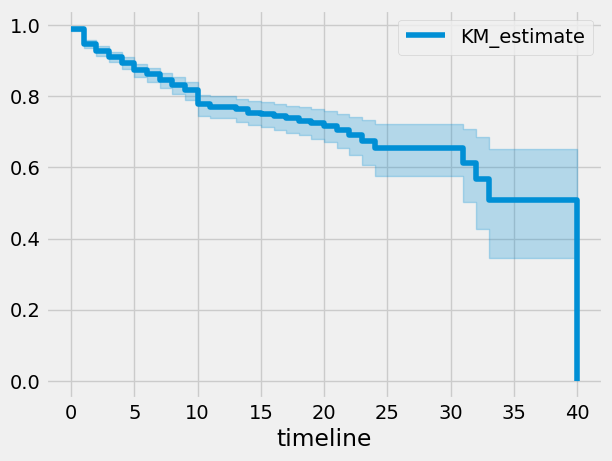

In [6]:
# Print survival probabilities at each year
kmf.survival_function_
# Plot the survival function with confidence intervals
kmf.plot_survival_function()
plt.show()

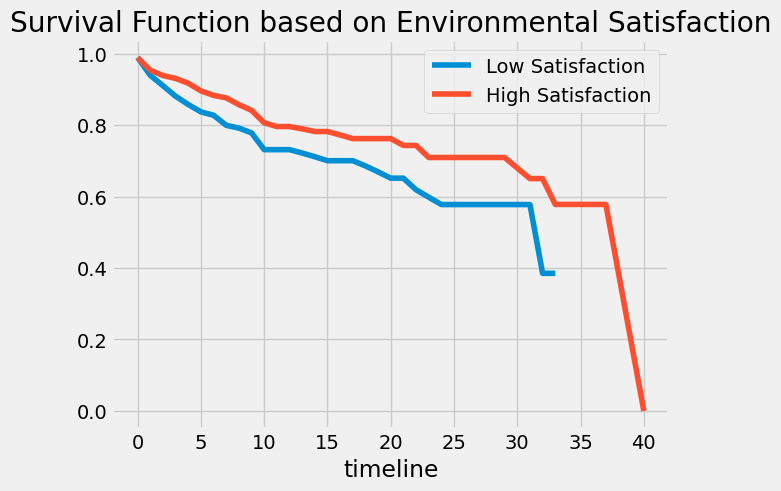

In [7]:
##Survival Function of Different Groups with KMF
# Define the low and high satisfaction
Low = ((df.EnvironmentSatisfaction == 1) | (df.EnvironmentSatisfaction == 2))
High = ((df.EnvironmentSatisfaction == 3) | (df.EnvironmentSatisfaction == 4))
# Plot the survival function
ax = plt.subplot()
kmf = KaplanMeierFitter()

kmf.fit(durations=df[Low].YearsAtCompany, event_observed=df[Low].Attrition, label='Low Satisfaction')
kmf.survival_function_.plot(ax=ax)
kmf.fit(durations=df[High].YearsAtCompany, event_observed=df[High].Attrition, label='High Satisfaction')
kmf.survival_function_.plot(ax=ax)
plt.title('Survival Function based on Environmental Satisfaction')
plt.show()

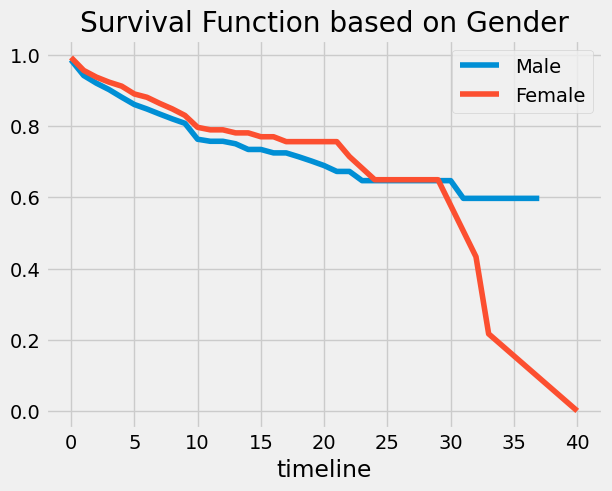

In [8]:
## Survival Function of Difference in Gender
male = (df["Gender"] == "Male")
female = (df["Gender"] == "Female")

ax = plt.subplot()
kmf = KaplanMeierFitter()

kmf.fit(durations=df[male]["YearsAtCompany"], event_observed=df[male]["Attrition"], label="Male")
kmf.survival_function_.plot(ax=ax)
kmf.fit(durations = df[female]["YearsAtCompany"], event_observed=df[female]["Attrition"], label = "Female")
kmf.survival_function_.plot(ax=ax)
plt.title("Survival Function based on Gender")
plt.show()

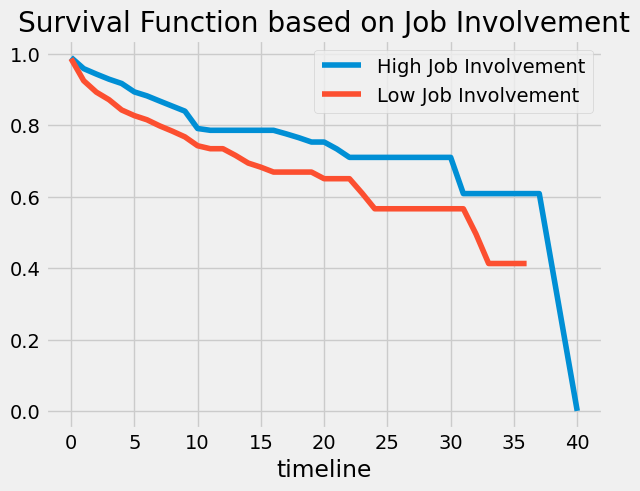

In [9]:
##Survival Function of Job Involvement Rating
high = (df["JobInvolvement"] == 3) | (df["JobInvolvement"] == 4)
low = (df["JobInvolvement"] == 1) | (df["JobInvolvement"] == 2)

ax = plt.subplot()
kmf = KaplanMeierFitter()

kmf.fit(durations=df[high].YearsAtCompany, event_observed=df[high].Attrition, label = "High Job Involvement")
kmf.survival_function_.plot(ax=ax)
kmf.fit(durations=df[low].YearsAtCompany, event_observed=df[low].Attrition, label = "Low Job Involvement")
kmf.survival_function_.plot(ax=ax)
plt.title("Survival Function based on Job Involvement")
plt.show()

In [10]:
#Log_rank hypothesis test for Gender
from lifelines.statistics import logrank_test
output = logrank_test(durations_A = df[male]['YearsAtCompany'],
                      durations_B = df[female]['YearsAtCompany'],
                      event_observed_A = df[male]['Attrition'],
                      event_observed_B = df[female]['Attrition'])
print(output.print_summary)


<bound method StatisticalResult.print_summary of <lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           1.79 0.18      2.47>


In [21]:
#Cox Proportional-Hazards Model
columns_selected = ['Attrition',
                    'EnvironmentSatisfaction',
                    'JobInvolvement',
                    'JobLevel',
                    'JobSatisfaction',
                    'PercentSalaryHike',
                    'RelationshipSatisfaction',
                    'StockOptionLevel', 
                    'TrainingTimesLastYear', 
                    'YearsAtCompany',
                    ]
df = df[columns_selected]
from lifelines import CoxPHFitter 

coxph = CoxPHFitter()
coxph.fit(df, 
          duration_col='YearsAtCompany',
          event_col='Attrition')


<lifelines.CoxPHFitter: fitted with 1470 total observations, 1233 right-censored observations>

In [18]:
##Predict Survival
#Current EE
df_new = df.loc[df['Attrition'] == 0]
#Years at the company of the current EE
df_new_obs = df_new['YearsAtCompany']
# Predict survival probabilities 
predictions = coxph.predict_survival_function(df_new,conditional_after=df_new_obs)
pd.DataFrame(predictions).head(11).iloc[:, :5]

,1,3,4,5,6
0.0,1.000000,1.000000,1.000000,1.000000,1.000000
1.0,0.986432,0.954723,0.960284,0.962204,0.988253
2.0,0.986432,0.832633,0.916395,0.921246,0.978083
3.0,0.967805,0.809508,0.861182,0.810189,0.966473
4.0,0.945323,0.809508,0.827520,0.789045,0.951264
5.0,0.932830,0.778306,0.780170,0.789045,0.941632
6.0,0.915764,0.741487,0.733267,0.760458,0.927576
7.0,0.896696,0.721424,0.683692,0.726633,0.913012
8.0,0.873145,0.694475,0.556009,0.708160,0.896843
9.0,0.842240,0.664989,0.532844,0.683295,0.850746


<lifelines.CoxPHFitter: fitted with 1470 total observations, 1233 right-censored observations>
             duration col = 'YearsAtCompany'
                event col = 'Attrition'
      baseline estimation = breslow
   number of observations = 1470
number of events observed = 237
   partial log-likelihood = -1449.16
         time fit was run = 2023-09-15 22:18:23 UTC

---
                           coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                        
EnvironmentSatisfaction   -0.24       0.79       0.06            -0.35            -0.12                 0.70                 0.89
JobInvolvement            -0.44       0.65       0.09            -0.61            -0.27                 0.55                 0.76
JobLevel                  -1.02       0.36       0.09            -1.20            -0.83                 0.30                 0.44
JobSatisfaction           -0.22       0.81       0.06            -0.33            -0.10                 0.72                 0.90
PercentSalaryHike         -0.01       0.99       0.02            -0.04             0.03                 0.96                 1.03
RelationshipSatisfaction  -0.08       0.92       0.06            -0.20             0.04                 0.82                 1.04
StockOptionLevel          -0.42       0.65       0.09            -0.60            -0.24                 0.55                 0.78
TrainingTimesLastYear     -0.17       0.85       0.05            -0.28            -0.06                 0.76                 0.94

                           cmp to      z      p   -log2(p)
covariate                                                 
EnvironmentSatisfaction      0.00  -4.00 <0.005      13.92
JobInvolvement               0.00  -5.08 <0.005      21.31
JobLevel                     0.00 -10.77 <0.005      87.49
JobSatisfaction              0.00  -3.77 <0.005      12.61
PercentSalaryHike            0.00  -0.44   0.66       0.60
RelationshipSatisfaction     0.00  -1.34   0.18       2.46
StockOptionLevel             0.00  -4.63 <0.005      18.04
TrainingTimesLastYear        0.00  -3.07 <0.005       8.84
---
Concordance = 0.79
Partial AIC = 2914.33
log-likelihood ratio test = 249.92 on 8 df
-log2(p) of ll-ratio test = 161.93

<Axes: xlabel='log(HR) (95% CI)'>

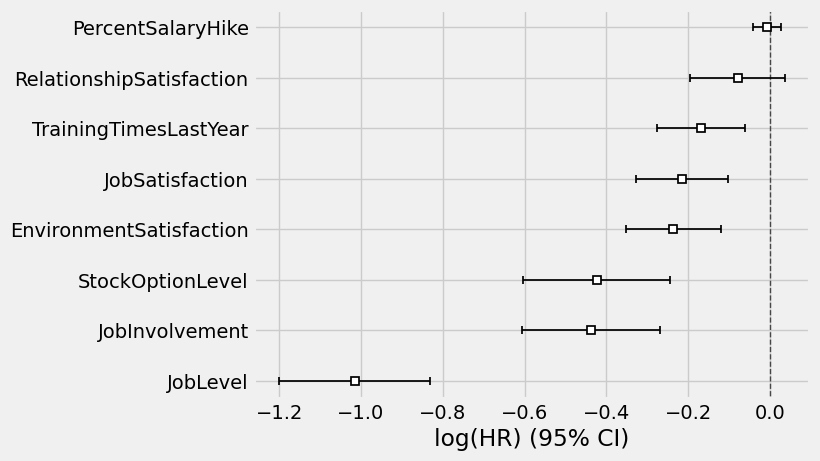

In [19]:
coxph.print_summary()
coxph.plot()

In [22]:
coxph.check_assumptions(df)


Proportional hazard assumption looks okay.


[]